In [986]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
from statsmodels.tools import add_constant
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from forestplot import forestplot
from scipy.stats import shapiro

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8')
plt.rcParams["figure.figsize"] = (12, 9)

In [987]:
'''
ppp=plt.get_cmap('autumn')
nn=5
my_colors=[ppp(i/nn) for i in range(nn)]
'''
#my_colors=['#40dfa5','#00c9b3','#00b1bc','#0099bd','#007fb4','#0065a2']
#my_colors=['#bbff99','#6ce5a2','#00c9ac','#00aab0','#008aac','#00699d']
#my_colors=['#7fb6d0','#8ac6d1','#89d1b8','#89d194']
my_colors=['#5bba99','#89d1b8','#b4e69b','#d9eddf']

In [988]:
df = pd.read_csv(r'C:\Users\17354\Downloads\Jiaotong-Preference-main\Jiaotong-Preference-main\cleaned_data.csv', index_col=0)
df.head()

,gender,major,grade,origin,money,1010,1011,1012,1013,0010,...,2102,2103,1110,1111,1112,1113,1000,1001,1002,1003
0,1,3,2,0,3000,0.435364,0.00000,0.564636,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0
1,1,1,2,2,4503,0.000000,0.00000,0.272892,0.727108,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,1.0
2,2,2,2,2,2134,0.000000,0.00000,1.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,1.0
3,2,2,2,1,2604,0.269976,0.32322,0.406804,0.000000,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.432907,0.567093,0.0
4,1,2,1,0,3000,0.399108,0.26753,0.333363,0.000000,0.189496,...,0.0,0.0,0.0,1.0,0.0,0.0,0.332225,0.367165,0.300610,0.0


## Basic Description

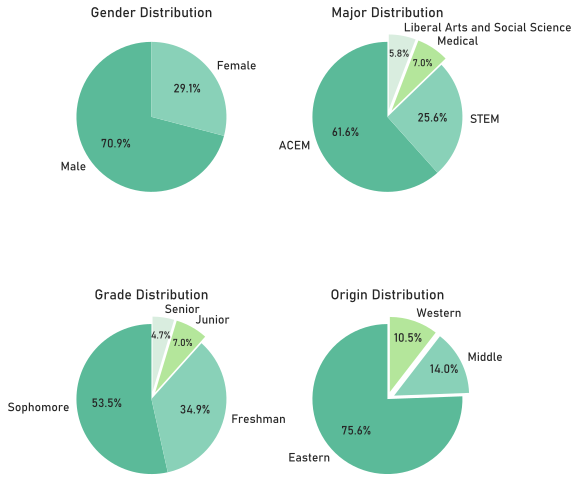

In [989]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=my_colors)
# 基本属性的一些饼图
properties = ['gender', 'major', 'grade', 'origin']
fig, axes = plt.subplots(2, 2, figsize=(8, 8), facecolor='white')
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False
for i, col in enumerate(properties):
    counts = df[col].value_counts()
    axelist=[]
    if i==0:
        axelist.append('Male')
        axelist.append("Female")
    elif i==1:
        axelist.append('ACEM')
        axelist.append('STEM')
        axelist.append('Medical')
        axelist.append("Liberal Arts and Social Science")
    elif i==2:
        axelist.append("Sophomore")
        axelist.append("Freshman")
        axelist.append("Junior")
        axelist.append("Senior")
    elif i==3:
        axelist.append("Eastern")
        axelist.append("Middle")
        axelist.append("Western")
    explode=[0.1 if i<0.2*sum(counts) else 0 for i in counts]
    ftsz=[10 if i<0.1*sum(counts) else 12 for i in counts]
    dstc=[1 if i<0.2*sum(counts) else 0.8 for i in counts]
    wedges,texts,autotexts=axes[i // 2, i % 2].pie(counts, labels=axelist, autopct='%1.1f%%', startangle=90,pctdistance=0.75,textprops={'fontsize': 12,'fontname':'Bahnschrift'},explode=explode)
    for autotexts,ftsz,dstc in zip(autotexts,ftsz,dstc):
        autotexts.set_fontsize(ftsz)
        autotexts.set_x(dstc*autotexts.get_position()[0])
        autotexts.set_y(dstc*autotexts.get_position()[1])
    axes[i // 2, i % 2].set_title(f'{col.capitalize()} Distribution', fontsize=14,fontname='Bahnschrift',fontweight='semibold')
plt.tight_layout()
plt.savefig("Distribution.svg")

## Pearson's $\chi^2$

In [990]:
# 先获取argmax表，描述每个学生的在不同情境下最偏好的选择
properties = ['gender', 'major', 'grade', 'origin', 'money']
situations = ['101', '001', '211', '000', '200', '011', '010', '110', '201', '210', '111', '100']

argmax_df = df.drop(columns=df.columns)
for i in situations:
    start, end = i + '0', i + '3'
    argmax_df[i] = np.argmax(df.loc[:, start:end], axis=1)
argmax_df

,101,001,211,000,200,011,010,110,201,210,111,100
0,2,2,0,3,0,0,1,2,0,0,0,0
1,3,3,1,3,1,1,3,3,1,1,1,3
2,2,2,1,3,0,2,3,2,1,0,1,3
3,2,2,0,3,0,1,3,3,1,0,1,2
4,0,2,1,2,0,3,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
81,0,0,1,0,0,1,1,0,1,0,1,0
82,2,2,1,2,1,1,1,0,1,0,1,1
83,2,2,0,2,0,1,2,2,0,0,1,0
84,1,1,1,1,1,1,1,1,1,1,1,1


In [991]:
# 归纳成频数表
chi_df = []
for i in situations:
    chi_df.append(argmax_df[i].value_counts())
chi_df = pd.concat(chi_df, axis=1)
chi_df.columns = situations
chi_df.fillna(0, inplace=True)
chi_df = chi_df.astype(int)
print(chi_df.index)
chi_df = chi_df.reindex(range(4))
chi_df

Index([2, 0, 1, 3], dtype='int64')


,101,001,211,000,200,011,010,110,201,210,111,100
0,35,7,38,9,67,14,13,36,35,68,7,41
1,11,9,46,6,16,43,30,19,50,16,77,16
2,36,63,1,56,2,20,25,21,0,1,0,26
3,4,7,1,15,1,9,18,10,1,1,2,3


In [992]:
chi2_res = chi2_contingency(chi_df)
f'chi^2: {chi2_res[0]}, p-value: {chi2_res[1]}, ddof: {chi2_res[2]}'

'chi^2: 662.6846892585919, p-value: 2.9492597207783935e-118, ddof: 33'

<Axes: >

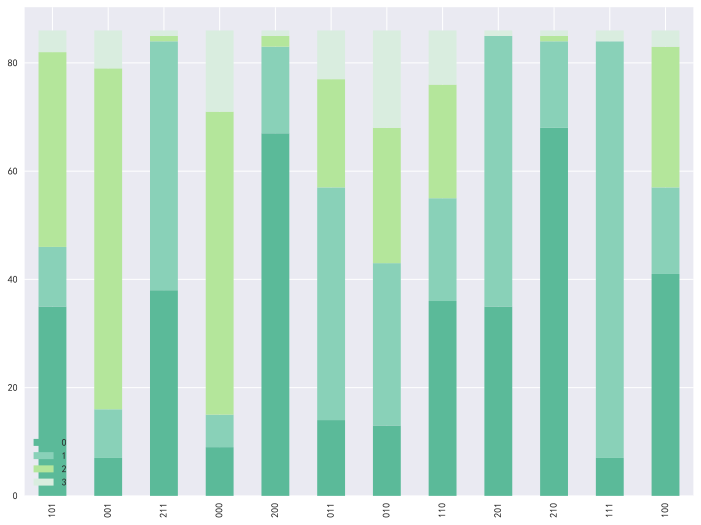

In [993]:
chi_df.T.plot(kind='bar', stacked=True)

In [994]:
# 观察一下每个格子的期望频数，都大于5就可以认为chi^2检验有效
row_sum, col_sum = chi_df.sum(axis=1), chi_df.sum(axis=0)
total = chi_df.sum().sum()
expected = np.outer(row_sum, col_sum) / total
expected = pd.DataFrame(expected, index=chi_df.index, columns=chi_df.columns)
expected

,101,001,211,000,200,011,010,110,201,210,111,100
0,30.833333,30.833333,30.833333,30.833333,30.833333,30.833333,30.833333,30.833333,30.833333,30.833333,30.833333,30.833333
1,28.250000,28.250000,28.250000,28.250000,28.250000,28.250000,28.250000,28.250000,28.250000,28.250000,28.250000,28.250000
2,20.916667,20.916667,20.916667,20.916667,20.916667,20.916667,20.916667,20.916667,20.916667,20.916667,20.916667,20.916667
3,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000


In [995]:
# 两两比较，先计算实际概率
mcp_probs = chi_df / col_sum
mcp_probs

,101,001,211,000,200,011,010,110,201,210,111,100
0,0.406977,0.081395,0.441860,0.104651,0.779070,0.162791,0.151163,0.418605,0.406977,0.790698,0.081395,0.476744
1,0.127907,0.104651,0.534884,0.069767,0.186047,0.500000,0.348837,0.220930,0.581395,0.186047,0.895349,0.186047
2,0.418605,0.732558,0.011628,0.651163,0.023256,0.232558,0.290698,0.244186,0.000000,0.011628,0.000000,0.302326
3,0.046512,0.081395,0.011628,0.174419,0.011628,0.104651,0.209302,0.116279,0.011628,0.011628,0.023256,0.034884


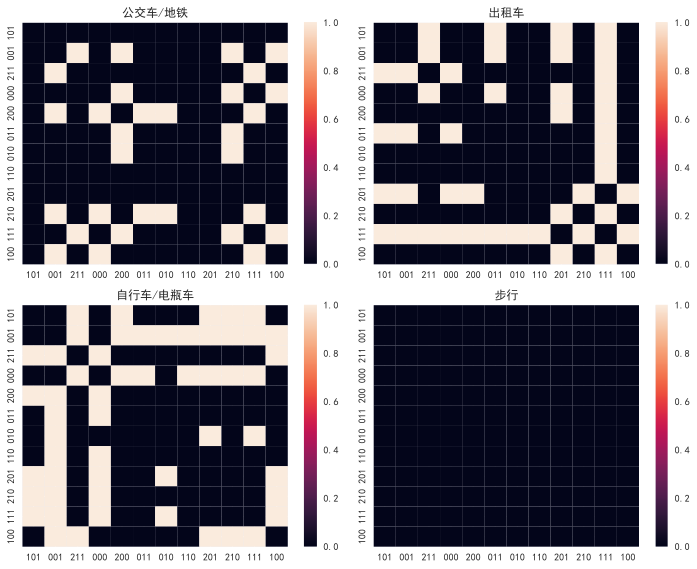

In [996]:
# 两两比较
# Bonferroni correction
alpha = 0.05 / (12 * 11 / 2)
# chi2_{alpha}(11)
crit = chi2.ppf(1 - alpha, 11)
significance = []
for i in range(4):

    delta = [abs(mcp_probs.loc[i, j] - mcp_probs.loc[i, k]) for j in situations for k in situations]
    delta = np.array(delta).reshape(12, -1)

    cv = [mcp_probs.loc[i, j] * (1 - mcp_probs.loc[i, j]) + mcp_probs.loc[i, k] * (1 - mcp_probs.loc[i, k]) for j in situations for k in situations]
    cv = np.array(cv).reshape(12, -1)
    cv = np.sqrt(cv * crit / len(df))
    significance_to_append = pd.DataFrame(delta > cv, index=situations, columns=situations)
    significance.append(significance_to_append)

plt.figure(figsize=(10, 8))
optionlist=['公交车/地铁','出租车','自行车/电瓶车','步行']
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False
for i, matrix in enumerate(significance):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(matrix, vmin=0, vmax=1)
    plt.title(optionlist[i])
plt.tight_layout()
plt.savefig('Ptest.svg',facecolor='white')

In [997]:
# further interpretation of figure
# 考虑自行车选择时间限制影响不大，受到距离/天气影响
# 哪个更重要
import scipy.stats
list1=[]
list2=[]
for i in df.columns:
    if i[3]=='2':
        if i[1]=='1':
            if i[0]=="2":
                list1.append(i)
            else:
                list2.append(i)
tdf1=pd.DataFrame({'2':df[list1].values.flatten()})
tdf2=pd.DataFrame({'not 2':df[list2].values.flatten()})
t,pval = scipy.stats.ttest_ind(tdf1,tdf2,alternative='less')
pval

array([1.18635265e-12])

In [998]:
# 考虑公交选择时间/天气影响不大，受到距离影响
anslist=[]
for j in range(3):
    for m in range(2):
        list1=[]
        list2=[]
        for i in df.columns:
            if i[0]==f'{j}' and i[3]=='1':
                if i[2]==f'{m}':
                    if i[1]=="0":
                        list1.append(i)
                    else:
                        list2.append(i)
        tdf1=pd.DataFrame({'2':df[list1].values.flatten()})
        tdf2=pd.DataFrame({'not 2':df[list2].values.flatten()})
        t,pval = scipy.stats.ttest_ind(tdf1,tdf2,alternative='two-sided')
        anslist.append(pval)
anslist

[array([5.95641355e-05]),
 array([8.67689385e-09]),
 array([0.75716165]),
 array([4.64753967e-38]),
 array([0.67478816]),
 array([0.97747339])]

## ANOVA

In [999]:
# 处理数据，交通工具选择是一个treatment
properties = ['gender', 'major', 'grade', 'origin', 'money']
anova_df = df.drop(columns=properties, axis=1)
anova_df = anova_df.melt(var_name='category', value_name='prob')
S = ['Distance', 'Weather', 'Constraint', 'Option']
for i, s in enumerate(S):
    anova_df[s] = anova_df['category'].str[i]
anova_df.drop(columns='category', axis=1, inplace=True)
anova_df[S] = anova_df[S].astype(int)
anova_df.head()

,prob,Distance,Weather,Constraint,Option
0,0.435364,1,0,1,0
1,0.000000,1,0,1,0
2,0.000000,1,0,1,0
3,0.269976,1,0,1,0
4,0.399108,1,0,1,0


In [1000]:
# 验证每个四元组的正态性、齐方差性和独立性
check_cols = list(set(df.columns.to_list()) - set(properties))
normal_flag = False
for i in check_cols:
    if shapiro(df[i])[1] >= 0.05:
        normal_flag = True
        print(f'{i} is normal')
if not normal_flag:
    print('No normal columns, we cannot use ANOVA')

No normal columns, we cannot use ANOVA


**So just IGNORE the codes in this part**

In [1001]:
n = len(S)
formula = f'prob ~ '
formula_to_append = []
for i in range(1, 2 ** n):
    # 把i转化为二进制数，用字符串格式
    i = bin(i)[2:]
    i = '0' * (n - len(i)) + i
    # 获取i中不为0的数的下标
    factors = [f'C({S[j]})' for j in range(n) if i[n - 1 - j] == '1']
    factor_to_append = ':'.join(factors)
    formula_to_append.append(factor_to_append)
formula_to_append =  ' + '.join(formula_to_append)
formula += formula_to_append
formula

'prob ~ C(Distance) + C(Weather) + C(Distance):C(Weather) + C(Constraint) + C(Distance):C(Constraint) + C(Weather):C(Constraint) + C(Distance):C(Weather):C(Constraint) + C(Option) + C(Distance):C(Option) + C(Weather):C(Option) + C(Distance):C(Weather):C(Option) + C(Constraint):C(Option) + C(Distance):C(Constraint):C(Option) + C(Weather):C(Constraint):C(Option) + C(Distance):C(Weather):C(Constraint):C(Option)'

In [1002]:
model = ols(formula, data=anova_df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(Distance),2.0,3.692593e-29,1.846297e-29,2.577151e-28,1.000000e+00
C(Weather),1.0,4.832266e-28,4.832266e-28,6.745114e-27,1.000000e+00
C(Constraint),1.0,4.218557e-28,4.218557e-28,5.888468e-27,1.000000e+00
C(Option),3.0,3.732582e+01,1.244194e+01,1.736707e+02,5.768125e-106
C(Distance):C(Weather),2.0,1.808702e-28,9.043512e-29,1.262338e-27,1.000000e+00
C(Distance):C(Constraint),2.0,1.967841e-28,9.839205e-29,1.373404e-27,1.000000e+00
C(Weather):C(Constraint),1.0,2.321667e-27,2.321667e-27,3.240696e-26,1.000000e+00
C(Distance):C(Option),6.0,6.046338e+01,1.007723e+01,1.406629e+02,1.625296e-162
C(Weather):C(Option),3.0,1.699202e+01,5.664007e+00,7.906098e+01,1.039729e-49
C(Constraint):C(Option),3.0,1.456533e+01,4.855110e+00,6.777001e+01,9.208605e-43


---

In [1003]:
def anova(df: pd.DataFrame, option: int):
    '''
    对某一个交通工具的softmax概率做anova
    '''
    zero_cols = df.columns[df.columns.str.endswith(str(option))]

    # 将所有0结尾的列转换为长格式
    zero_df = df[zero_cols].melt(var_name='category', value_name='prob')
    S = ['Distance', 'Weather', 'Constraint']
    for i, s in enumerate(S):
        zero_df[s] = zero_df['category'].str[i]

    zero_df.drop('category', axis=1, inplace=True)
    zero_df[S] = zero_df[S].astype(int)

    formula = f'prob ~ C({S[0]}) + C({S[1]}) + C({S[2]}) + C({S[0]}):C({S[1]}) + C({S[0]}):C({S[2]}) + C({S[1]}):C({S[2]}) + C({S[0]}):C({S[1]}):C({S[2]})'
    model = ols(formula, zero_df).fit()
    anova_res = anova_lm(model)

    return anova_res

In [1004]:
anova(df, 0)

,df,sum_sq,mean_sq,F,PR(>F)
C(Distance),2.0,25.704493,12.852246,158.374513,1.260813e-60
C(Weather),1.0,0.267547,0.267547,3.296901,6.970422e-02
C(Constraint),1.0,2.948794,2.948794,36.337135,2.316561e-09
C(Distance):C(Weather),2.0,1.691500,0.845750,10.421931,3.307035e-05
C(Distance):C(Constraint),2.0,3.676023,1.838012,22.649284,2.375212e-10
C(Weather):C(Constraint),1.0,0.081415,0.081415,1.003256,3.167614e-01
C(Distance):C(Weather):C(Constraint),2.0,0.262162,0.131081,1.615275,1.993441e-01
Residual,1020.0,82.773997,0.081151,NaN,NaN


In [1005]:
anova(df, 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(Distance),2.0,4.767242,2.383621,25.541614,1.500535e-11
C(Weather),1.0,9.788587,9.788587,104.889297,1.693486e-23
C(Constraint),1.0,10.376253,10.376253,111.186411,9.574503e-25
C(Distance):C(Weather),2.0,4.817967,2.408984,25.813386,1.158442e-11
C(Distance):C(Constraint),2.0,1.849894,0.924947,9.911240,5.456252e-05
C(Weather):C(Constraint),1.0,3.878330,3.878330,41.558121,1.762262e-10
C(Distance):C(Weather):C(Constraint),2.0,5.323056,2.661528,28.519520,8.872590e-13
Residual,1020.0,95.189494,0.093323,NaN,NaN


In [1006]:
anova(df, 2)

,df,sum_sq,mean_sq,F,PR(>F)
C(Distance),2.0,25.264952,12.632476,186.241284,1.130593e-69
C(Weather),1.0,6.935398,6.935398,102.248959,5.678035e-23
C(Constraint),1.0,0.268616,0.268616,3.960224,4.685411e-02
C(Distance):C(Weather),2.0,3.491657,1.745829,25.738849,1.243622e-11
C(Distance):C(Constraint),2.0,0.279014,0.139507,2.056757,1.283980e-01
C(Weather):C(Constraint),1.0,1.799275,1.799275,26.526811,3.118443e-07
C(Distance):C(Weather):C(Constraint),2.0,1.794274,0.897137,13.226539,2.133094e-06
Residual,1020.0,69.185118,0.067829,NaN,NaN


In [1007]:
anova(df, 3)

,df,sum_sq,mean_sq,F,PR(>F)
C(Distance),2.0,4.726694,2.363347,53.395220,8.832411e-23
C(Weather),1.0,0.000488,0.000488,0.011027,9.163907e-01
C(Constraint),1.0,0.971667,0.971667,21.952929,3.172332e-06
C(Distance):C(Weather),2.0,0.138526,0.069263,1.564866,2.096177e-01
C(Distance):C(Constraint),2.0,0.727463,0.363732,8.217806,2.880719e-04
C(Weather):C(Constraint),1.0,0.117405,0.117405,2.652526,1.036943e-01
C(Distance):C(Weather):C(Constraint),2.0,0.266390,0.133195,3.009280,4.976532e-02
Residual,1020.0,45.146627,0.044261,NaN,NaN


## Multinomial Logistic Regression

In [1008]:
properties = ['gender', 'major', 'grade', 'origin', 'money']
df2 = df[properties].copy()
# 把money转为zscore
df2['money'] = (df2['money'] - df2['money'].mean()) / df2['money'].std()

situations = ['101', '001', '211', '000', '200', '011', '010', '110', '201', '210', '111', '100']
for i in situations:
    start, end = i + '0', i + '3'
    # In case of multiple occurrences of the maximum values, 
    # the indices corresponding to the first occurrence are returned.
    preferences = np.argmax(df.loc[:, start:end], axis=1)
    df2[i] = preferences
df2.head()

,gender,major,grade,origin,money,101,001,211,000,200,011,010,110,201,210,111,100
0,1,3,2,0,-0.026633,2,2,0,3,0,0,1,2,0,0,0,0
1,1,1,2,2,0.955822,3,3,1,3,1,1,3,3,1,1,1,3
2,2,2,2,2,-0.592705,2,2,1,3,0,2,3,2,1,0,1,3
3,2,2,2,1,-0.285483,2,2,0,3,0,1,3,3,1,0,1,2
4,1,2,1,0,-0.026633,0,2,1,2,0,3,1,0,1,1,1,1


In [1009]:
df2 = df2.melt(
    id_vars=properties, 
    value_vars=situations, 
    var_name='situation', 
    value_name='preference'
)
S = ['Distance', 'Weather', 'Constraint']
for i, s in enumerate(S):
    df2[s] = df2['situation'].str[i]

df2.drop('situation', axis=1, inplace=True)
df2[S] = df2[S].astype(int)
df2.head()

,gender,major,grade,origin,money,preference,Distance,Weather,Constraint
0,1,3,2,0,-0.026633,2,1,0,1
1,1,1,2,2,0.955822,3,1,0,1
2,2,2,2,2,-0.592705,2,1,0,1
3,2,2,2,1,-0.285483,2,1,0,1
4,1,2,1,0,-0.026633,0,1,0,1


In [1010]:
# 获取独热编码
one_hot_cols = ['gender', 'major', 'grade', 'origin', 'Distance']
df2 = pd.get_dummies(df2, columns=one_hot_cols, drop_first=True, dtype=int)
df2.head()

,money,preference,Weather,Constraint,gender_2,major_2,major_3,major_4,grade_2,grade_3,grade_4,origin_1,origin_2,Distance_1,Distance_2
0,-0.026633,2,0,1,0,0,1,0,1,0,0,0,0,1,0
1,0.955822,3,0,1,0,0,0,0,1,0,0,0,1,1,0
2,-0.592705,2,0,1,1,1,0,0,1,0,0,0,1,1,0
3,-0.285483,2,0,1,1,1,0,0,1,0,0,1,0,1,0
4,-0.026633,0,0,1,0,1,0,0,0,0,0,0,0,1,0


In [1011]:
X = df2.drop('preference', axis=1)
X = add_constant(X)
logit_model = sm.MNLogit(df2['preference'], X)
logit_res = logit_model.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.912499
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             preference   No. Observations:                 1032
Model:                        MNLogit   Df Residuals:                      987
Method:                           MLE   Df Model:                           42
Date:                Thu, 02 Jan 2025   Pseudo R-squ.:                  0.2776
Time:                        19:05:14   Log-Likelihood:                -941.70
converged:                       True   LL-Null:                       -1303.5
Covariance Type:            nonrobust   LLR p-value:                4.825e-125
================================================================================
preference=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.5448      0.329     -1.656      0.098      -1.190       0.100
money            0.3744      0.101      3.689      0.000       0.176       0.573
Weather          0.9064      0.172      5.260      0.000       0.569       1.244
Constraint       1.4965      0.172      8.723      0.000       1.160       1.833
gender_2         0.1824      0.201      0.908      0.364      -0.211       0.576
major_2          0.1234      0.203      0.609      0.543      -0.274       0.521
major_3         -0.2288      0.463     -0.494      0.621      -1.136       0.678
major_4         -0.3625      0.390     -0.930      0.352      -1.127       0.402
grade_2         -0.5091      0.194     -2.626      0.009      -0.889      -0.129
grade_3         -0.2125      0.360     -0.590      0.555      -0.918       0.493
grade_4         -0.7400      0.536     -1.380      0.168      -1.791       0.311
origin_1         0.1735      0.273      0.636      0.525      -0.361       0.708
origin_2         0.7581      0.303      2.499      0.012       0.163       1.353
Distance_1      -0.6037      0.241     -2.508      0.012      -1.076      -0.132
Distance_2      -1.1166      0.237     -4.710      0.000      -1.581      -0.652
--------------------------------------------------------------------------------
preference=2       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2290      0.348      6.403      0.000       1.547       2.911
money           -0.0759      0.138     -0.552      0.581      -0.346       0.194
Weather         -1.3245      0.218     -6.082      0.000      -1.751      -0.898
Constraint       0.4247      0.210      2.025      0.043       0.014       0.836
gender_2        -0.3932      0.258     -1.526      0.127      -0.898       0.112
major_2         -0.1477      0.247     -0.597      0.550      -0.632       0.337
major_3         -0.3124      0.575     -0.543      0.587      -1.440       0.815
major_4         -0.2180      0.479     -0.455      0.649      -1.157       0.721
grade_2         -0.7277      0.242     -3.004      0.003      -1.202      -0.253
grade_3         -0.2230      0.432     -0.516      0.606      -1.070       0.624
grade_4          0.5600      0.573      0.977      0.329      -0.563       1.683
origin_1         1.0510      0.319      3.290      0.001       0.425       1.677
origin_2         0.3346      0.417      0.803      0.422      -0.482       1.152
Distance_1      -1.8897      0.238     -7.944      0.000      -2.356      -1.424
Distance_2      -5.6620      0.546    -10.373      0.000      -6.732      -4.592
--------------------------------------------------------------------------------
preference=3       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0102      0.501      0.020      0.984      -0.972       0.992
m

In [1012]:
# 提取回归系数
params = logit_res.params  # 回归系数
stderr = logit_res.bse  # 标准误差
conf_int = logit_res.conf_int()  # 置信区间
pvalues = logit_res.pvalues  # P值

In [1013]:
def get_coef_df(params, stderr, conf_int, pvalues, preference):
    '''
    提取某一类的回归系数及相关信息
    注意preference=0已经被当作基准类，preference=1对应的是第二类
    '''
    coef_df = pd.DataFrame({
        'coef': params.loc[:, preference - 1],
        'var_err': stderr.loc[:, preference - 1] ** 2,
        'p_value': pvalues.loc[:, preference - 1],
        'conf_low': conf_int.loc[str(preference), 'lower'],
        'conf_high': conf_int.loc[str(preference), 'upper']
    })
    coef_df.reset_index(inplace=True)
    coef_df.rename(columns={'index': 'variable'}, inplace=True)
    return coef_df

coef_df1 = get_coef_df(params, stderr, conf_int, pvalues, 1)
coef_df2 = get_coef_df(params, stderr, conf_int, pvalues, 2)
coef_df3 = get_coef_df(params, stderr, conf_int, pvalues, 3)

# 示例
coef_df1

,variable,coef,var_err,p_value,conf_low,conf_high
0,const,-0.544792,0.108239,9.773840e-02,-1.189613,0.100030
1,money,0.374428,0.010301,2.249668e-04,0.175505,0.573351
2,Weather,0.906393,0.029690,1.438157e-07,0.568675,1.244110
3,Constraint,1.496479,0.029432,2.710912e-18,1.160233,1.832724
4,gender_2,0.182441,0.040358,3.638013e-01,-0.211304,0.576187
5,major_2,0.123416,0.041127,5.428113e-01,-0.274059,0.520890
6,major_3,-0.228783,0.214199,6.210748e-01,-1.135887,0.678321
7,major_4,-0.362544,0.152020,3.524511e-01,-1.126728,0.401640
8,grade_2,-0.509050,0.037592,8.652071e-03,-0.889061,-0.129039
9,grade_3,-0.212517,0.129562,5.549153e-01,-0.917999,0.492966


In [1014]:
fp = lambda coef_df: forestplot(
    dataframe=coef_df,
    estimate='coef',
    varlabel='variable',
    ll='conf_low',
    hl='conf_high',
    pval='p_value',
    title='Regression Coefficients (preference=1)',
    xlabel='Coefficient Value',
    fontsize=12
)

<Axes: xlabel='Coefficient Value'>

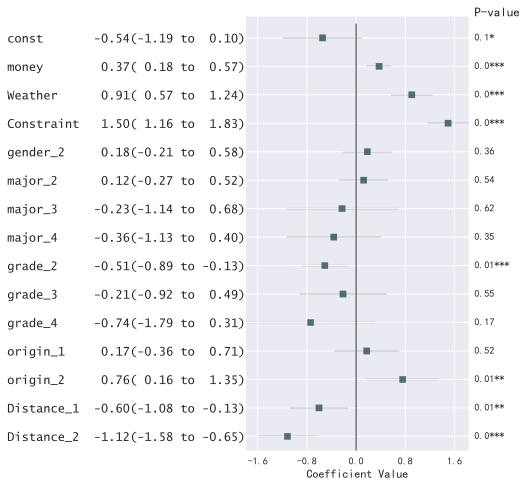

In [1015]:
fp(coef_df1)

<Axes: xlabel='Coefficient Value'>

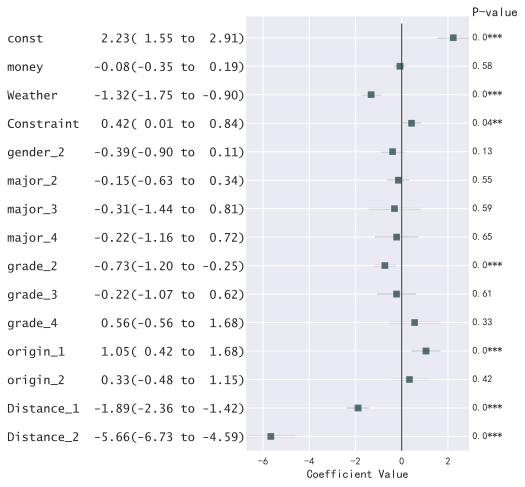

In [1016]:
fp(coef_df2)

<Axes: xlabel='Coefficient Value'>

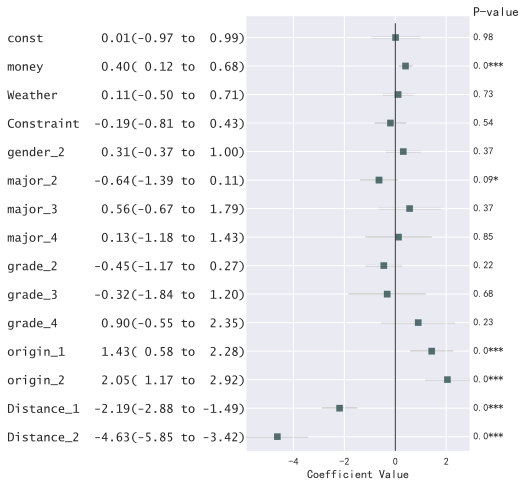

In [1017]:
fp(coef_df3)